## Imports

In [1]:
# %cd /home/liamroy/Documents/PHD/repos/RL_audio/notebooks

%cd '/Users/liamroy/Library/CloudStorage/GoogleDrive-liam.roy@monash.edu/My Drive/LIAM ROY - ROBOTICS/User Study 02 - Auto State Expression/RL_audio/notebooks'

# %cd <add your path here and comment out the others>

/Users/liamroy/Library/CloudStorage/GoogleDrive-liam.roy@monash.edu/My Drive/LIAM ROY - ROBOTICS/User Study 02 - Auto State Expression/RL_audio/notebooks


In [38]:
# IMPORTS
import os
import shutil
import time
import sys
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.ticker import FormatStrFormatter


from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

from scipy import stats

from termcolor import colored, cprint
# Termcolor guide: https://pypi.org/project/termcolor/

from openpyxl import Workbook
from openpyxl import load_workbook

%matplotlib widget
# %matplotlib inline
# %matplotlib notebook

# Try to use this website to use the explode feature, so we can see internal blocks and space everything out
# https://terbium.io/2017/12/matplotlib-3d/ 

# Use this website to make your GIFs - generally 50 delay per frame is good
# https://ezgif.com/maker

## Initializations

In [3]:
def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def plot_3d_array(vox_array, save_str, title_str, plotter=True, norm_min=-10, norm_max=10, scale_label="action value", colour_map="RdYlGn"):
    ''' Plots a 3D array using voxels. 
        vox_array = your 3D aray as a .npz file
        save_str  = what you want the filename to be saved as
        title_str = the title for your plot
        plotter   = whether you want the plot saved (None) or plotted in this notebook (True)
        norm_min  = what the minimum on scale is 
        norm_max  = what the maximum on scale is
        scale_label = obvious
        colour_map = how the colour is mapped - see link: https://matplotlib.org/stable/tutorials/colors/colormaps.html'''
    
    
    # Create the figure
    fig = plt.figure(figsize=(14, 12))

    # Make it a 3D plot
    ax = fig.add_subplot(projection='3d')

    plt.title(f"{title_str}", size=20, y=0.95)

    
    # Set title, axes and ticks
    # ax.set_title(f"{title_str}", size=25)

    ax.set_xticks([]) # for minor ticks --> ax.set_xticks([], minor=True)
    ax.set_yticks([])
    ax.set_zticks([])

    ax.set_xlabel('100      -      140      -      180\n\nBeat Per Min', size=15)
    ax.set_ylabel('1   -  2   -  4\n\nBeat Per Loop', size=15)
    ax.set_zlabel('Neg   -   Neutral   -   Pos\n\nPitch Bend', size=15)


    # Set no grid and desired view angle
    ax.grid(False)
    ax.view_init(8, 285)


    # Define the colour map
    cmap = plt.get_cmap(colour_map)
    # norm= plt.Normalize(vox_array.min(), vox_array.max())
    norm= plt.Normalize(norm_min, norm_max)


    # Creates an array with a 1 at each location of the array where we want a voxel, then explode
    filled = np.ones_like(vox_array)
    filled = explode(filled)

    # Create a colourmap & explode
    colors = cmap(norm(vox_array), alpha=0.85)
    colors = explode(colors)
        
        
    # Plot the voxels 
    ax.voxels(filled, facecolors=colors, edgecolors='black', shade=False)


    # To get the colour bar (note scatter size is set to zero - workaround since no cbar w/ voxels)
    counter = range(3)
    x,y,z = np.meshgrid(counter, counter, counter)
    scatter_cube = ax.scatter(x,y,z, c=vox_array.flat, cmap=plt.get_cmap(colour_map), s=0, alpha=0.8, linewidths=2, edgecolors="black", vmin=norm_min, vmax=norm_max)
    cbar = fig.colorbar(scatter_cube, shrink=0.45, orientation="vertical", aspect=8, pad=0.05) # Add a color bar
    cbar.minorticks_off()
    cbar.set_label(f'\n{scale_label}', rotation=90, size=15)


    # Save the fig
    plt.savefig(save_str, bbox_inches='tight', pad_inches=0.25)

    # Show the fig if plotter is not set to None
    if plotter:
        plt.show()

    
    if plotter == None:
        print(" Plots closed. ")
        matplotlib.pyplot.close()


# Matrix Plottter

## Mean of All User Final Matrices

For every condition there are 9 arrays --> 3 for each state:

- 3 for each state which take the mean of all the final Q-values of sect2X from all users

- 3 for each state which take the mean of all the final Q-values of sect2O from all users

- 3 for each state which take the mean of all the combined Q-values of sect2X and sect2O from all users

### Run this one to save heaps of photos which capture ALL users :3

Plottter saves all as .png files


In [4]:
# Initializations ( NO SET REQUIRED ) 
param_disc = 3

user_ID_save_str = "all"          

condition_list = ["all", "condA", "condB"]

all_list = [*range(3, 27)]
condA_list = [3, 4, 5, 6, 7, 8, 9, 10, 22, 23, 24, 25]
condB_list = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 26] 


# For each of the three conditions:   
# "all"   = looking at all users
# "condA" = only looking at users from condA 
# "condB" = only looking at users from condB

for condition_str in condition_list:

    # For each of the 3 states
    for state_index in range(0, 3):

        # Reset user counter for sanity check & final calcs
        users_count = 0

        # Reset total array to zeros 
        total_array_sect2X = np.zeros((param_disc, param_disc, param_disc))
        total_array_sect2O = np.zeros((param_disc, param_disc, param_disc))
        total_array_combined = np.zeros((param_disc, param_disc, param_disc))

        
        # Select which users to consider based on condition
        if condition_str == "all":
            user_list = all_list
        
        elif condition_str == "condA":
            user_list = condA_list
            
        elif condition_str == "condB":
            user_list = condB_list
        else:
            print("ERROR at user_list")
            
            
            
        # Then for each user..
        for user_idx in user_list:

            users_count += 1

            user_ID_load_str = f"{user_idx:02}"
            # print("\nUSER: ", user_ID_load_str, "\n")

            user_array_sect2X = np.load("user_data/user_" + user_ID_load_str + "/arrays/" + user_ID_load_str + "_sect2X_final_st" + str(state_index) + ".npy")
            user_array_sect2O = np.load("user_data/user_" + user_ID_load_str + "/arrays/" + user_ID_load_str + "_sect2O_final_st" + str(state_index) + ".npy")

            total_array_sect2X += user_array_sect2X
            total_array_sect2O += user_array_sect2O
            total_array_combined += user_array_sect2X + user_array_sect2O



        # Sanity check of how many users considered in this batch (all, condA, or condB)    
        print(users_count, "users count:")
        

        # These arrays have just been summed, divide by number of users to get the mean
        total_array_sect2X = total_array_sect2X / users_count
        total_array_sect2O = total_array_sect2O / users_count
        total_array_combined = total_array_combined / (users_count*2.)


        # Calculate standard dev of each matrix:
        total_array_sect2X_std = np.std(total_array_sect2X)
        total_array_sect2O_std = np.std(total_array_sect2O)
        total_array_combined_std = np.std(total_array_combined)


        # Save the arrays:
        np.save("user_data/user_all/arrays/" + condition_str + "_sect2X_st" + str(state_index) + ".npy", total_array_sect2X)
        np.save("user_data/user_all/arrays/" + condition_str + "_sect2O_st" + str(state_index) + ".npy", total_array_sect2O)
        np.save("user_data/user_all/arrays/" + condition_str + "_combined_st" + str(state_index) + ".npy", total_array_combined)


        # Sanity check of shape / values of the arrays 
        print(f"{condition_str}_sect2X_st{str(state_index)}_array: ", total_array_sect2X.shape)
        print(f"{condition_str}_sect2O_st{str(state_index)}_array: ", total_array_sect2O.shape)
        print(f"{condition_str}_combined_st{str(state_index)}_array: ", total_array_combined.shape)
        print()


        # Create the save strings for the array plots
        sect2X_array_save_str = f"user_data/user_all/{condition_str}_st{state_index}_sect2X_plot.png"  # You can swap order: "_st{state_index" with "_sect2X_plot"
        sect2O_array_save_str = f"user_data/user_all/{condition_str}_st{state_index}_sect2O_plot.png"
        combined_array_save_str = f"user_data/user_all/{condition_str}_st{state_index}_combined_plot.png"


        # Create the title strings
        if state_index == 0:

            sect2X_title_str =   f"Mean Q-Values for Sect 2X Only\nState 0: Stuck  -  Condition: {condition_str}  -  Std: {total_array_sect2X_std:.3f}"
            sect2O_title_str =   f"Mean Q-Values for Sect 20 Only\nState 0: Stuck  -  Condition: {condition_str}  -  Std: {total_array_sect2O_std:.3f}"
            combined_title_str = f"Mean Q-Values Combining 2X and 2O\nState 0: Stuck  -  Condition: {condition_str}  -  Std: {total_array_combined_std:.3f}"

        elif state_index == 1:

            sect2X_title_str =   f"Mean Q-Values for Sect 2X Only\nState 1: Accomplished  -  Condition: {condition_str}  -  Std: {total_array_sect2X_std:.3f}"
            sect2O_title_str =   f"Mean Q-Values for Sect 20 Only\nState 1: Accomplished  -  Condition: {condition_str}  -  Std: {total_array_sect2O_std:.3f}"
            combined_title_str = f"Mean Q-Values Combining 2X and 2O\nState 1: Accomplished  -  Condition: {condition_str}  -  Std: {total_array_combined_std:.3f}"


        elif state_index == 2:

            sect2X_title_str =   f"Mean Q-Values for Sect 2X Only\nState 2: Progressing  -  Condition: {condition_str}  -  Std: {total_array_sect2X_std:.3f}"
            sect2O_title_str =   f"Mean Q-Values for Sect 20 Only\nState 2: Progressing  -  Condition: {condition_str}  -  Std: {total_array_sect2O_std:.3f}"
            combined_title_str = f"Mean Q-Values Combining 2X and 2O\nState 2: Progressing  -  Condition: {condition_str}  -  Std: {total_array_combined_std:.3f}"


        else:
            print("ERROR")


        plot_3d_array(total_array_sect2X, sect2X_array_save_str, sect2X_title_str, plotter=None)

        plot_3d_array(total_array_sect2O, sect2O_array_save_str, sect2O_title_str, plotter=None)

        plot_3d_array(total_array_combined, combined_array_save_str, combined_title_str, plotter=None)
        
        print()

24 users count:
all_sect2X_st0_array:  (3, 3, 3)
all_sect2O_st0_array:  (3, 3, 3)
all_combined_st0_array:  (3, 3, 3)

 Plots closed. 
 Plots closed. 
 Plots closed. 

24 users count:
all_sect2X_st1_array:  (3, 3, 3)
all_sect2O_st1_array:  (3, 3, 3)
all_combined_st1_array:  (3, 3, 3)

 Plots closed. 
 Plots closed. 
 Plots closed. 

24 users count:
all_sect2X_st2_array:  (3, 3, 3)
all_sect2O_st2_array:  (3, 3, 3)
all_combined_st2_array:  (3, 3, 3)

 Plots closed. 
 Plots closed. 
 Plots closed. 

12 users count:
condA_sect2X_st0_array:  (3, 3, 3)
condA_sect2O_st0_array:  (3, 3, 3)
condA_combined_st0_array:  (3, 3, 3)

 Plots closed. 
 Plots closed. 
 Plots closed. 

12 users count:
condA_sect2X_st1_array:  (3, 3, 3)
condA_sect2O_st1_array:  (3, 3, 3)
condA_combined_st1_array:  (3, 3, 3)

 Plots closed. 
 Plots closed. 
 Plots closed. 

12 users count:
condA_sect2X_st2_array:  (3, 3, 3)
condA_sect2O_st2_array:  (3, 3, 3)
condA_combined_st2_array:  (3, 3, 3)

 Plots closed. 
 Plots closed

## Single User Matrix Plottter

Plottter saves all as .png files

Run this one to save heaps of photos for a single user :3

In [5]:
# Initializations ( PLEASE SET WHICH USER )
user_ID_str = "15"

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
max_steps_to_plot = 100
param_disc = 3

section_str_list = ["2X", "2O"]

step_nums = []

for i in range(0, max_steps_to_plot):    # remember this is non inclusive of the last number 
    step_nums.append("step" + f"{i:02}")

step_nums.append("final")           
          
    
# For both sect2X and sect2O
for section_str in section_str_list:

    print(f"\nSection: sect{section_str}")
    
    counter = 0

    for step_num in step_nums:

        print(step_num)

        if step_num == "step00":
            if section_str == "2O":       
                st0_array = np.load("user_data/user_" + user_ID_str + "/arrays/pilotset_st0.npy")
                st1_array = np.load("user_data/user_" + user_ID_str + "/arrays/pilotset_st1.npy")
                st2_array = np.load("user_data/user_" + user_ID_str + "/arrays/pilotset_st2.npy")

            elif section_str == "2X": # dont start with the initialized Q-table
                st0_array = np.ones((param_disc, param_disc, param_disc)) * 10.0
                st1_array = np.ones((param_disc, param_disc, param_disc)) * 10.0
                st2_array = np.ones((param_disc, param_disc, param_disc)) * 10.0

            else:
                print("ERROR at arrays")
                
            st0_array_std = np.std(st0_array)
            st1_array_std = np.std(st1_array)
            st2_array_std = np.std(st2_array)

            st0_array_save_str = "user_data/user_" + user_ID_str + "/sect" + section_str + f"_st0_plot{counter:02}_{step_num}.png" 
            st1_array_save_str = "user_data/user_" + user_ID_str + "/sect" + section_str + f"_st1_plot{counter:02}_{step_num}.png" 
            st2_array_save_str = "user_data/user_" + user_ID_str + "/sect" + section_str + f"_st2_plot{counter:02}_{step_num}.png" 

            step_str = step_num # ex: could be "step03" or "final"

            st0_title_str = f"User {user_ID_str} Q-values  -  Sect{section_str} @ {step_str}\nState 0: Stuck  -  Std: {st0_array_std:.3f}" 
            st1_title_str = f"User {user_ID_str} Q-values  -  Sect{section_str} @ {step_str}\nState 1: Accomplished  -  Std: {st1_array_std:.3f}" 
            st2_title_str = f"User {user_ID_str} Q-values  -  Sect{section_str} @ {step_str}\nState 2: Progressing  -  Std: {st2_array_std:.3f}" 

            print(f"running plotter @ {step_num}")
            plot_3d_array(st0_array, st0_array_save_str, st0_title_str, plotter=None)
            plot_3d_array(st1_array, st1_array_save_str, st1_title_str, plotter=None)
            plot_3d_array(st2_array, st2_array_save_str, st2_title_str, plotter=None)

            counter += 1
            continue 


        step_str = step_num # ex: could be "step03" or "final"
        load_file = user_ID_str + "_sect" + section_str + "_" + step_str

        st0_array_path_str = "user_data/user_" + user_ID_str + "/arrays/" + load_file + "_st0.npy"
        st1_array_path_str = "user_data/user_" + user_ID_str + "/arrays/" + load_file + "_st1.npy"
        st2_array_path_str = "user_data/user_" + user_ID_str + "/arrays/" + load_file + "_st2.npy"

        try:

            st0_array = np.load(st0_array_path_str)
            st1_array = np.load(st1_array_path_str)
            st2_array = np.load(st2_array_path_str)

            st0_array_std = np.std(st0_array)
            st1_array_std = np.std(st1_array)
            st2_array_std = np.std(st2_array)

            st0_array_save_str = "user_data/user_" + user_ID_str + "/sect" + section_str + f"_st0_plot{counter:02}_{step_num}.png" 
            st1_array_save_str = "user_data/user_" + user_ID_str + "/sect" + section_str + f"_st1_plot{counter:02}_{step_num}.png" 
            st2_array_save_str = "user_data/user_" + user_ID_str + "/sect" + section_str + f"_st2_plot{counter:02}_{step_num}.png" 

            st0_title_str = f"User {user_ID_str} Q-values  -  Sect{section_str} @ {step_str}\nState 0: Stuck  -  Std: {st0_array_std:.3f}" 
            st1_title_str = f"User {user_ID_str} Q-values  -  Sect{section_str} @ {step_str}\nState 1: Accomplished  -  Std: {st1_array_std:.3f}" 
            st2_title_str = f"User {user_ID_str} Q-values  -  Sect{section_str} @ {step_str}\nState 2: Progressing  -  Std: {st2_array_std:.3f}" 

            print(f"running plotter @ {step_num}")
            plot_3d_array(st0_array, st0_array_save_str, st0_title_str, plotter=None)
            plot_3d_array(st1_array, st1_array_save_str, st1_title_str, plotter=None)
            plot_3d_array(st2_array, st2_array_save_str, st2_title_str, plotter=None)

            counter += 1

        except FileNotFoundError:
            print(f"No file: {step_num}")
            continue


Section: sect2X
step00
running plotter @ step00
 Plots closed. 
 Plots closed. 
 Plots closed. 
step01
running plotter @ step01
 Plots closed. 
 Plots closed. 
 Plots closed. 
step02
running plotter @ step02
 Plots closed. 
 Plots closed. 
 Plots closed. 
step03
running plotter @ step03
 Plots closed. 
 Plots closed. 
 Plots closed. 
step04
running plotter @ step04
 Plots closed. 
 Plots closed. 
 Plots closed. 
step05
running plotter @ step05
 Plots closed. 
 Plots closed. 
 Plots closed. 
step06
running plotter @ step06
 Plots closed. 
 Plots closed. 
 Plots closed. 
step07
running plotter @ step07
 Plots closed. 
 Plots closed. 
 Plots closed. 
step08
running plotter @ step08
 Plots closed. 
 Plots closed. 
 Plots closed. 
step09
running plotter @ step09
 Plots closed. 
 Plots closed. 
 Plots closed. 
step10
running plotter @ step10
 Plots closed. 
 Plots closed. 
 Plots closed. 
step11
running plotter @ step11
 Plots closed. 
 Plots closed. 
 Plots closed. 
step12
running plotter 

## Single Matrix Plotter for Conf Report

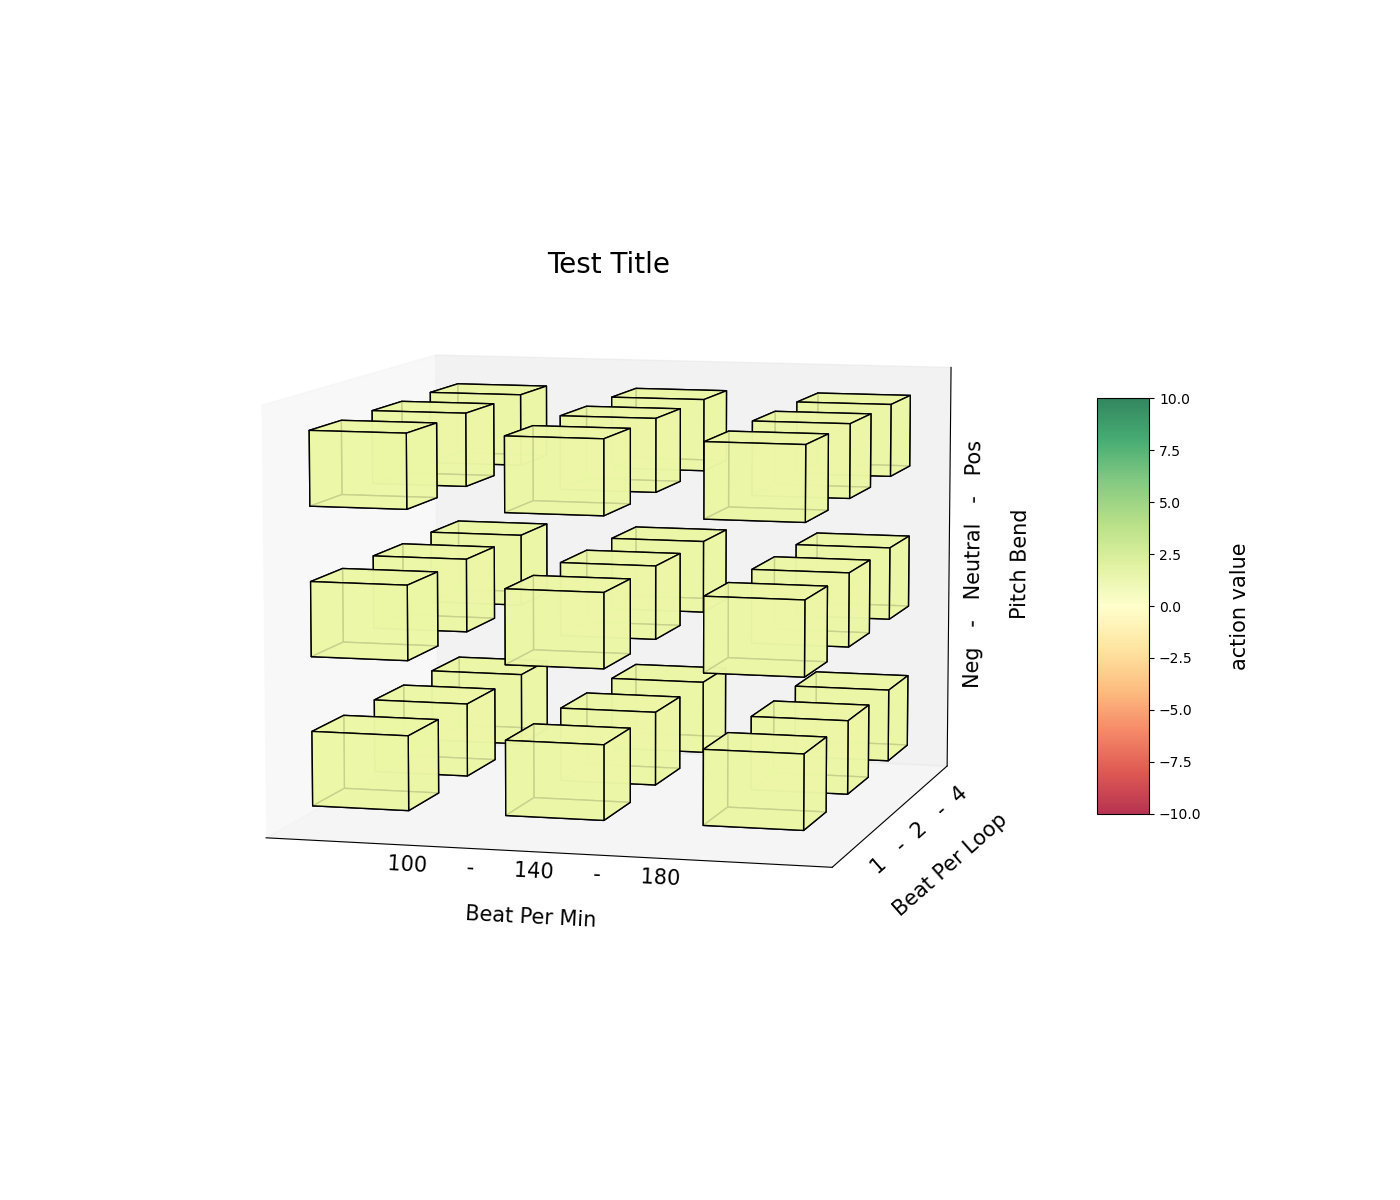

In [6]:
single_array = np.ones((3,3,3))

single_title_str = "Test Title"

single_save_str = "images/text_vox_plot.png"

plot_3d_array(single_array, single_save_str, single_title_str, plotter=True)

In [7]:
print(" Plots closed. ")
matplotlib.pyplot.close()

 Plots closed. 


## Now Calculate the variance (standard dev)
Calculate the standard deviation of final q-values for each of our states 

In all we will have
- 3 states (stuck, accomplished, progressing)

- 2 conditions (sect2X, sect2O)

- 27 values per state (3x3x3 matrix)

There will be 6 matrices total, each with 27 values --> Plottter saves all as .png files

In [8]:
# Initializations ( NO SET REQUIRED ) 
param_disc = 3

condition_list = ["sect2X", "sect2O"]

all_list = [*range(3, 27)]


for condition_str in condition_list:

    std_array_st0 = np.zeros((param_disc, param_disc, param_disc))
    std_array_st1 = np.zeros((param_disc, param_disc, param_disc))
    std_array_st2 = np.zeros((param_disc, param_disc, param_disc))
    
    mean_array_st0 = np.zeros((param_disc, param_disc, param_disc))
    mean_array_st1 = np.zeros((param_disc, param_disc, param_disc))
    mean_array_st2 = np.zeros((param_disc, param_disc, param_disc))    
    
    print(f"****************************************************\nCONDITON: {condition_str}\n****************************************************\n")
    
    # Itterate param indecies.
    # Recall: param_0 = Speed of audio loop (BPM)         --> (100 BPM   //  140 BPM  //  180 BPM)
    #         param_1 = Number of beeps per loop (BPL)   --> (1 BPL     //  2 BPM     //  4 BPL) 
    #         param_2 = Amplitude of Pitch Bend           --> (downward  //  neutral  //  upward)

    for param_0_idx in range(0, 3):
        for param_1_idx in range(0, 3):
            for param_2_idx in range(0, 3):

                # Reset varriance list to empty
                st0_var_list = [] 
                st1_var_list = [] 
                st2_var_list = [] 


                for user_ID_idx in all_list:
                    user_ID_load_str = f"{user_ID_idx:02}"
                    load_file = user_ID_load_str + "_" + condition_str + "_final"

                    st0_array_path_str = "user_data/user_" + user_ID_load_str + "/arrays/" + load_file + "_st0.npy"
                    st1_array_path_str = "user_data/user_" + user_ID_load_str + "/arrays/" + load_file + "_st1.npy"
                    st2_array_path_str = "user_data/user_" + user_ID_load_str + "/arrays/" + load_file + "_st2.npy"
                    # print(st0_array_path_str)
                    # print(st1_array_path_str)
                    # print(st2_array_path_str)
                    # print()

                    st0_var_list.append(np.load(st0_array_path_str)[param_0_idx, param_1_idx, param_2_idx])

                    st1_var_list.append(np.load(st1_array_path_str)[param_0_idx, param_1_idx, param_2_idx])

                    st2_var_list.append(np.load(st2_array_path_str)[param_0_idx, param_1_idx, param_2_idx])

                print(f"INDEX: {param_0_idx} {param_1_idx} {param_2_idx}")
                print("st0_var_list:", len(st0_var_list), st0_var_list)
                print("st1_var_list:", len(st1_var_list), st1_var_list)
                print("st2_var_list:", len(st2_var_list), st2_var_list)
                print()

                st0_var_list_std = np.std(st0_var_list)
                st1_var_list_std = np.std(st1_var_list)
                st2_var_list_std = np.std(st2_var_list)
                
                print("st0_var_list_std:", st0_var_list_std)
                print("st1_var_list_std:", st1_var_list_std)
                print("st2_var_list_std:", st2_var_list_std)
                print()
                
                st0_var_list_mean = np.mean(st0_var_list)
                st1_var_list_mean = np.mean(st1_var_list)
                st2_var_list_mean = np.mean(st2_var_list)
                
                print("st0_var_list_mean:", st0_var_list_mean)
                print("st1_var_list_mean:", st1_var_list_mean)
                print("st2_var_list_mean:", st2_var_list_mean)
                print()

                std_array_st0[param_0_idx, param_1_idx, param_2_idx] = st0_var_list_std
                std_array_st1[param_0_idx, param_1_idx, param_2_idx] = st1_var_list_std
                std_array_st2[param_0_idx, param_1_idx, param_2_idx] = st2_var_list_std
                
                mean_array_st0[param_0_idx, param_1_idx, param_2_idx] = st0_var_list_mean
                mean_array_st1[param_0_idx, param_1_idx, param_2_idx] = st1_var_list_mean
                mean_array_st2[param_0_idx, param_1_idx, param_2_idx] = st2_var_list_mean
            
                
    print("std_array_st0:\n", std_array_st0, "\n\n")
    print("std_array_st1:\n", std_array_st1, "\n\n")
    print("std_array_st2:\n", std_array_st2, "\n\n")
    
    print("mean_array_st0:\n", mean_array_st0, "\n\n")
    print("mean_array_st1:\n", mean_array_st1, "\n\n")
    print("mean_array_st2:\n", mean_array_st2, "\n\n")
    
    # Save the arrays:
    np.save("user_data/user_all/arrays/st0_variance_" + condition_str + "_matrix.npy", std_array_st0)    
    np.save("user_data/user_all/arrays/st1_variance_" + condition_str + "_matrix.npy", std_array_st1)    
    np.save("user_data/user_all/arrays/st2_variance_" + condition_str + "_matrix.npy", std_array_st2)    
    
    np.save("user_data/user_all/arrays/st0_mean_" + condition_str + "_matrix.npy", mean_array_st0)    
    np.save("user_data/user_all/arrays/st1_mean_" + condition_str + "_matrix.npy", mean_array_st1)    
    np.save("user_data/user_all/arrays/st2_mean_" + condition_str + "_matrix.npy", mean_array_st2)    

****************************************************
CONDITON: sect2X
****************************************************

INDEX: 0 0 0
st0_var_list: 24 [9.0, 8.0, -1.0, 8.0, 9.5, 10.0, 8.5, 5.0, 0.0, 8.0, -5.0, -2.0, 10.0, 10.0, 9.0, 9.0, 2.0, 0.0, 8.5, 10.0, 9.0, 7.0, 8.0, 9.0]
st1_var_list: 24 [-9.0, -8.0, -1.0, -8.0, -9.5, -10.0, -8.5, -5.0, 0.0, -8.0, -5.0, -2.0, -10.0, -10.0, -9.0, -9.0, -2.0, 0.0, -8.5, -10.0, -9.0, -7.0, -8.0, -9.0]
st2_var_list: 24 [-9.0, -8.0, 1.0, -8.0, -9.5, -10.0, -8.5, -5.0, 0.0, -8.0, 5.0, 2.0, -10.0, -10.0, -9.0, -9.0, -2.0, 0.0, -8.5, -10.0, -9.0, -7.0, -8.0, -9.0]

st0_var_list_std: 4.437010927665406
st1_var_list_std: 3.307123519347625
st2_var_list_std: 4.437010927665406

st0_var_list_mean: 6.229166666666667
st1_var_list_mean: -6.895833333333333
st2_var_list_mean: -6.229166666666667

INDEX: 0 0 1
st0_var_list: 24 [-5.0, -5.0, -5.0, -4.0, 1.0, -9.0, -9.0, -2.0, -8.0, -6.5, -8.0, -2.0, -9.0, -8.0, 2.0, -9.0, -8.0, -4.5, -7.0, -10.0, -8.5, 9.5, -6.0, -9

### Now plot all the variance matrices

In [9]:
condition_list = ["sect2X", "sect2O"]

for condition_str in condition_list:
        
    var_array_st0 = np.load("user_data/user_all/arrays/st0_variance_" + condition_str + "_matrix.npy")
    var_array_st1 = np.load("user_data/user_all/arrays/st1_variance_" + condition_str + "_matrix.npy")
    var_array_st2 = np.load("user_data/user_all/arrays/st2_variance_" + condition_str + "_matrix.npy")

    mean_array_st0 = np.load("user_data/user_all/arrays/st0_mean_" + condition_str + "_matrix.npy")
    mean_array_st1 = np.load("user_data/user_all/arrays/st1_mean_" + condition_str + "_matrix.npy")
    mean_array_st2 = np.load("user_data/user_all/arrays/st2_mean_" + condition_str + "_matrix.npy")
    
    
    
    var_array_save_str_st0 = "user_data/user_all/st0_variance_" + condition_str + "_matrix.png" 
    var_array_save_str_st1 = "user_data/user_all/st1_variance_" + condition_str + "_matrix.png" 
    var_array_save_str_st2 = "user_data/user_all/st2_variance_" + condition_str + "_matrix.png" 

    mean_array_save_str_st0 = "user_data/user_all/st0_mean_" + condition_str + "_matrix.png" 
    mean_array_save_str_st1 = "user_data/user_all/st1_mean_" + condition_str + "_matrix.png" 
    mean_array_save_str_st2 = "user_data/user_all/st2_mean_" + condition_str + "_matrix.png" 


    
    upper_condition_str = condition_str[0].upper() + condition_str[1:]
    var_array_title_str_st0 = f"{upper_condition_str} Variance Matrix - State 0: Stuck" 
    var_array_title_str_st1 = f"{upper_condition_str} Variance Matrix - State 1: Accomplished" 
    var_array_title_str_st2 = f"{upper_condition_str} Variance Matrix - State 2: Progressing" 
    
    mean_array_title_str_st0 = f"{upper_condition_str} Mean Matrix - State 0: Stuck" 
    mean_array_title_str_st1 = f"{upper_condition_str} Mean Matrix - State 1: Accomplished" 
    mean_array_title_str_st2 = f"{upper_condition_str} Mean Matrix - State 2: Progressing" 


    print(f"running plotter @ {step_num}")
    plot_3d_array(var_array_st0, var_array_save_str_st0, var_array_title_str_st0, plotter=None, norm_min=0., norm_max=8., scale_label="variance")
    plot_3d_array(var_array_st1, var_array_save_str_st1, var_array_title_str_st1, plotter=None, norm_min=0., norm_max=8., scale_label="variance")
    plot_3d_array(var_array_st2, var_array_save_str_st2, var_array_title_str_st2, plotter=None, norm_min=0., norm_max=8., scale_label="variance")
    
    plot_3d_array(mean_array_st0, mean_array_save_str_st0, mean_array_title_str_st0, plotter=None)
    plot_3d_array(mean_array_st1, mean_array_save_str_st1, mean_array_title_str_st1, plotter=None)
    plot_3d_array(mean_array_st2, mean_array_save_str_st2, mean_array_title_str_st2, plotter=None)

running plotter @ final
 Plots closed. 
 Plots closed. 
 Plots closed. 
 Plots closed. 
 Plots closed. 
 Plots closed. 
running plotter @ final
 Plots closed. 
 Plots closed. 
 Plots closed. 
 Plots closed. 
 Plots closed. 
 Plots closed. 


# User Section State Selections

## Test to see if users had internal consistency between section 2X and 2O

In [10]:
def get_user_section_state_idxs(user_ID):
    
    # Enter the data in spreadsheet format
    workbook_path = "user_data/response_book.xlsx"
    response_book = load_workbook(workbook_path)
    
    try: # Try to open existing sheet
        response_sheet = response_book.get_sheet_by_name("conv_idx")
    except KeyError:  # If ot doesn't exist. create it
        response_sheet = response_book.create_sheet(title="conv_idx")
        
    
# ROW 1
    response_sheet["A1"] = "user ID"
    response_sheet.merge_cells('A1:A2')

    # STATE 0 - Stuck
    response_sheet["B1"] = "St0 - STUCK - Sect2X"
    response_sheet.merge_cells('B1:D1')
    response_sheet["E1"] = "St0 - STUCK - Sect2O"
    response_sheet.merge_cells('E1:G1')
    response_sheet["H1"] = "St0 - STUCK - Matched"
    response_sheet.merge_cells('H1:J1')

    # STATE 1 - Accomplished
    response_sheet["L1"] = "St1 - ACCOM - Sect2X"
    response_sheet.merge_cells('L1:N1')
    response_sheet["O1"] = "St1 - ACCOM - Sect2O"
    response_sheet.merge_cells('O1:Q1')
    response_sheet["R1"] = "St1 - ACCOM - Matched"
    response_sheet.merge_cells('R1:T1')
    
    # STATE 2 - Progressing
    response_sheet["V1"] = "St2 - PROGR - Sect2X"
    response_sheet.merge_cells('V1:X1')
    response_sheet["Y1"] = "St2 - PROGR - Sect2O"
    response_sheet.merge_cells('Y1:AA1')
    response_sheet["AB1"] = "St2 - PROGR - Matched"
    response_sheet.merge_cells('AB1:AD1')
    
    
# ROW 2
    # STATE 0
    response_sheet["B2"] = "P1"
    response_sheet["C2"] = "P2"
    response_sheet["D2"] = "P3"
    response_sheet["E2"] = "P1"
    response_sheet["F2"] = "P2"
    response_sheet["G2"] = "P3"
    response_sheet["H2"] = "P1"
    response_sheet["I2"] = "P2"
    response_sheet["J2"] = "P3"

    # STATE 1
    response_sheet["L2"] = "P1"
    response_sheet["M2"] = "P2"
    response_sheet["N2"] = "P3"
    response_sheet["O2"] = "P1"
    response_sheet["P2"] = "P2"
    response_sheet["Q2"] = "P3"
    response_sheet["R2"] = "P1"
    response_sheet["S2"] = "P2"
    response_sheet["T2"] = "P3"
    
    # STATE 2
    response_sheet["V2"] = "P1"
    response_sheet["W2"] = "P2"
    response_sheet["X2"] = "P3"
    response_sheet["Y2"] = "P1"
    response_sheet["Z2"] = "P2"
    response_sheet["AA2"] = "P3"
    response_sheet["AB2"] = "P1"
    response_sheet["AC2"] = "P2"
    response_sheet["AD2"] = "P3"
    
    
    user_ID_str = str("{:02d}".format(user_ID))    
    
    sect2X_st0 = np.load("user_data/user_" + user_ID_str + "/arrays/" + user_ID_str + "_sect2X_final_st0.npy") # Stuck
    sect2X_st1 = np.load("user_data/user_" + user_ID_str + "/arrays/" + user_ID_str + "_sect2X_final_st1.npy") # Accomplished 
    sect2X_st2 = np.load("user_data/user_" + user_ID_str + "/arrays/" + user_ID_str + "_sect2X_final_st2.npy") # Progressing
    

    sect2X_st0_max_idx = np.unravel_index(np.argmax(sect2X_st0),sect2X_st0.shape)
    # print(sect2X_st0)
    # print(sect2X_st0_max_idx)
    # print()
    
    sect2X_st1_max_idx = np.unravel_index(np.argmax(sect2X_st1),sect2X_st1.shape)
    # print(sect2X_st1)
    # print(sect2X_st1_max_idx)
    # print()
    
    sect2X_st2_max_idx = np.unravel_index(np.argmax(sect2X_st2),sect2X_st2.shape)
    # print(sect2X_st2)
    # print(sect2X_st2_max_idx)
    # print()
    
    
    sect2O_st0 = np.load("user_data/user_" + user_ID_str + "/arrays/" + user_ID_str + "_sect2O_final_st0.npy") # Stuck
    sect2O_st1 = np.load("user_data/user_" + user_ID_str + "/arrays/" + user_ID_str + "_sect2O_final_st1.npy") # Accomplished 
    sect2O_st2 = np.load("user_data/user_" + user_ID_str + "/arrays/" + user_ID_str + "_sect2O_final_st2.npy") # Progressing
    

    sect2O_st0_max_idx = np.unravel_index(np.argmax(sect2O_st0),sect2O_st0.shape)
    # print(sect2O_st0)
    # print(sect2O_st0_max_idx)
    # print()
    
    sect2O_st1_max_idx = np.unravel_index(np.argmax(sect2O_st1),sect2O_st1.shape)
    # print(sect2O_st1)
    # print(sect2O_st1_max_idx)
    # print()
    
    sect2O_st2_max_idx = np.unravel_index(np.argmax(sect2O_st2),sect2O_st2.shape)
    # print(sect2O_st2)
    # print(sect2O_st2_max_idx)
    # print()
    
    
    # Recall    
    # param_1 = Speed of audio loop (BPM)		 --> (100 BPM   //  140 BPM  //  180 BPM)
    # param_2 = Number of beeps per loop (BPL)   --> (1 BPL	 //  2 BPM	 //  4 BPL) 
    # param_3 = Amplitude of Pitch Bend  		 --> (downward  //  neutral  //  upward)
    
    
    
    # Enter the values for tat user
        
    response_sheet["A"+str(user_ID)] = user_ID
    
    response_sheet["B"+str(user_ID)] = sect2X_st0_max_idx[0]
    response_sheet["C"+str(user_ID)] = sect2X_st0_max_idx[1]
    response_sheet["D"+str(user_ID)] = sect2X_st0_max_idx[2]
    response_sheet["E"+str(user_ID)] = sect2O_st0_max_idx[0]
    response_sheet["F"+str(user_ID)] = sect2O_st0_max_idx[1]
    response_sheet["G"+str(user_ID)] = sect2O_st0_max_idx[2]
    # response_sheet["H"+str(user_ID)] = 
    # response_sheet["I"+str(user_ID)] = 
    # response_sheet["J"+str(user_ID)] = 
    
    response_sheet["L"+str(user_ID)] = sect2X_st1_max_idx[0]
    response_sheet["M"+str(user_ID)] = sect2X_st1_max_idx[1]
    response_sheet["N"+str(user_ID)] = sect2X_st1_max_idx[2]
    response_sheet["O"+str(user_ID)] = sect2O_st1_max_idx[0]
    response_sheet["P"+str(user_ID)] = sect2O_st1_max_idx[1]
    response_sheet["Q"+str(user_ID)] = sect2O_st1_max_idx[2]
    # response_sheet["R"+str(user_ID)] = 
    # response_sheet["S"+str(user_ID)] = 
    # response_sheet["T"+str(user_ID)] = 
    
    response_sheet["V"+str(user_ID)] = sect2X_st2_max_idx[0]
    response_sheet["W"+str(user_ID)] = sect2X_st2_max_idx[1]
    response_sheet["X"+str(user_ID)] = sect2X_st2_max_idx[2]
    response_sheet["Y"+str(user_ID)] = sect2O_st2_max_idx[0]
    response_sheet["Z"+str(user_ID)] = sect2O_st2_max_idx[1]
    response_sheet["AA"+str(user_ID)] = sect2O_st2_max_idx[2]
    # response_sheet["AB"+str(user_ID)] = 
    # response_sheet["AC"+str(user_ID)] = 
    # response_sheet["AD"+str(user_ID)] = 
    

    response_book.save(workbook_path)
    
    return sect2X_st0_max_idx, sect2X_st1_max_idx, sect2X_st2_max_idx, sect2O_st0_max_idx, sect2O_st1_max_idx, sect2O_st2_max_idx
    


In [11]:
param_disc = 3

sect2X_st0_hist_matrix = np.zeros((param_disc, param_disc, param_disc))
sect2X_st1_hist_matrix = np.zeros((param_disc, param_disc, param_disc))
sect2X_st2_hist_matrix = np.zeros((param_disc, param_disc, param_disc))

sect2O_st0_hist_matrix = np.zeros((param_disc, param_disc, param_disc))
sect2O_st1_hist_matrix = np.zeros((param_disc, param_disc, param_disc))
sect2O_st2_hist_matrix = np.zeros((param_disc, param_disc, param_disc))


all_list = [*range(3, 27)]
# condA_list = [3, 4, 5, 6, 7, 8, 9, 10, 22, 23, 24, 25]
# condB_list = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 26] 

for user_num in all_list:
    user_sect2X_st0_max_idx, user_sect2X_st1_max_idx, user_sect2X_st2_max_idx, user_sect2O_st0_max_idx, user_sect2O_st1_max_idx, user_sect2O_st2_max_idx = get_user_section_state_idxs(user_num)
    
    sect2X_st0_hist_matrix[user_sect2X_st0_max_idx[0], user_sect2X_st0_max_idx[1], user_sect2X_st0_max_idx[2]] += 1
    sect2X_st1_hist_matrix[user_sect2X_st1_max_idx[0], user_sect2X_st1_max_idx[1], user_sect2X_st1_max_idx[2]] += 1
    sect2X_st2_hist_matrix[user_sect2X_st2_max_idx[0], user_sect2X_st2_max_idx[1], user_sect2X_st2_max_idx[2]] += 1

    sect2O_st0_hist_matrix[user_sect2O_st0_max_idx[0], user_sect2O_st0_max_idx[1], user_sect2O_st0_max_idx[2]] += 1
    sect2O_st1_hist_matrix[user_sect2O_st1_max_idx[0], user_sect2O_st1_max_idx[1], user_sect2O_st1_max_idx[2]] += 1
    sect2O_st2_hist_matrix[user_sect2O_st2_max_idx[0], user_sect2O_st2_max_idx[1], user_sect2O_st2_max_idx[2]] += 1
    
    
print(f"sect2X_st0_hist_matrix: \n{sect2X_st0_hist_matrix}")
print()
print(f"sect2X_st1_hist_matrix: \n{sect2X_st1_hist_matrix}")
print()
print(f"sect2X_st2_hist_matrix: \n{sect2X_st2_hist_matrix}")
print()
print(f"sect2O_st0_hist_matrix: \n{sect2O_st0_hist_matrix}")
print()
print(f"sect2O_st1_hist_matrix: \n{sect2O_st1_hist_matrix}")
print()
print(f"sect2O_st2_hist_matrix: \n{sect2O_st2_hist_matrix}")

/var/folders/vx/sqc7hy3d7tzbzb4vn45c7n8h0000gn/T/ipykernel_21175/842523670.py:8: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  response_sheet = response_book.get_sheet_by_name("conv_idx")


sect2X_st0_hist_matrix: 
[[[9. 1. 0.]
  [1. 0. 0.]
  [4. 0. 0.]]

 [[2. 0. 0.]
  [0. 0. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [0. 0. 0.]
  [5. 0. 0.]]]

sect2X_st1_hist_matrix: 
[[[0. 0. 3.]
  [0. 1. 2.]
  [0. 1. 1.]]

 [[0. 0. 2.]
  [0. 0. 2.]
  [0. 0. 1.]]

 [[0. 0. 2.]
  [0. 0. 5.]
  [1. 1. 2.]]]

sect2X_st2_hist_matrix: 
[[[0. 5. 1.]
  [0. 2. 0.]
  [0. 1. 1.]]

 [[0. 5. 0.]
  [0. 1. 0.]
  [0. 0. 0.]]

 [[0. 5. 0.]
  [0. 1. 0.]
  [0. 2. 0.]]]

sect2O_st0_hist_matrix: 
[[[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 4.  1.  0.]]

 [[ 0.  2.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 1.  0.  0.]
  [15.  1.  0.]]]

sect2O_st1_hist_matrix: 
[[[ 0.  0.  1.]
  [ 0.  0.  1.]
  [ 0.  0.  1.]]

 [[ 0.  1.  2.]
  [ 0.  0. 16.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  1.]
  [ 1.  0.  0.]]]

sect2O_st2_hist_matrix: 
[[[ 0.  1.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0. 16.  0.]
  [ 0.  4.  0.]
  [ 0.  0.  0.]]

 [[ 0.  3.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]]


## Now plot each matrix to view distribution

In [13]:
sect2X_st0_hist_matrix_save = "user_data/user_all/heatmaps/sect2X_st0_conv_heatmap.png"
sect2X_st0_hist_matrix_title = "Section 2X: Uninformed Initialization \nConvergence Heatmap State 0: Stuck"

sect2X_st1_hist_matrix_save = "user_data/user_all/heatmaps/sect2X_st1_conv_heatmap.png"
sect2X_st1_hist_matrix_title = "Section 2X: Uninformed Initialization \nConvergence Heatmap State 1: Accomplished"

sect2X_st2_hist_matrix_save = "user_data/user_all/heatmaps/sect2X_st2_conv_heatmap.png"
sect2X_st2_hist_matrix_title = "Section 2X: Uninformed Initialization \nConvergence Heatmap State 2: Progressing"

sect2O_st0_hist_matrix_save = "user_data/user_all/heatmaps/sect2O_st0_conv_heatmap.png"
sect2O_st0_hist_matrix_title = "Section 2O: Informed Initialization \nConvergence Heatmap State 0: Stuck"

sect2O_st1_hist_matrix_save = "user_data/user_all/heatmaps/sect2O_st1_conv_heatmap.png"
sect2O_st1_hist_matrix_title = "Section 2O: Informed Initialization \nConvergence Heatmap State 1: Accomplished"

sect2O_st2_hist_matrix_save = "user_data/user_all/heatmaps/sect2O_st2_conv_heatmap.png"
sect2O_st2_hist_matrix_title = "Section 2O: Informed Initialization \nConvergence Heatmap State 2: Progressing"

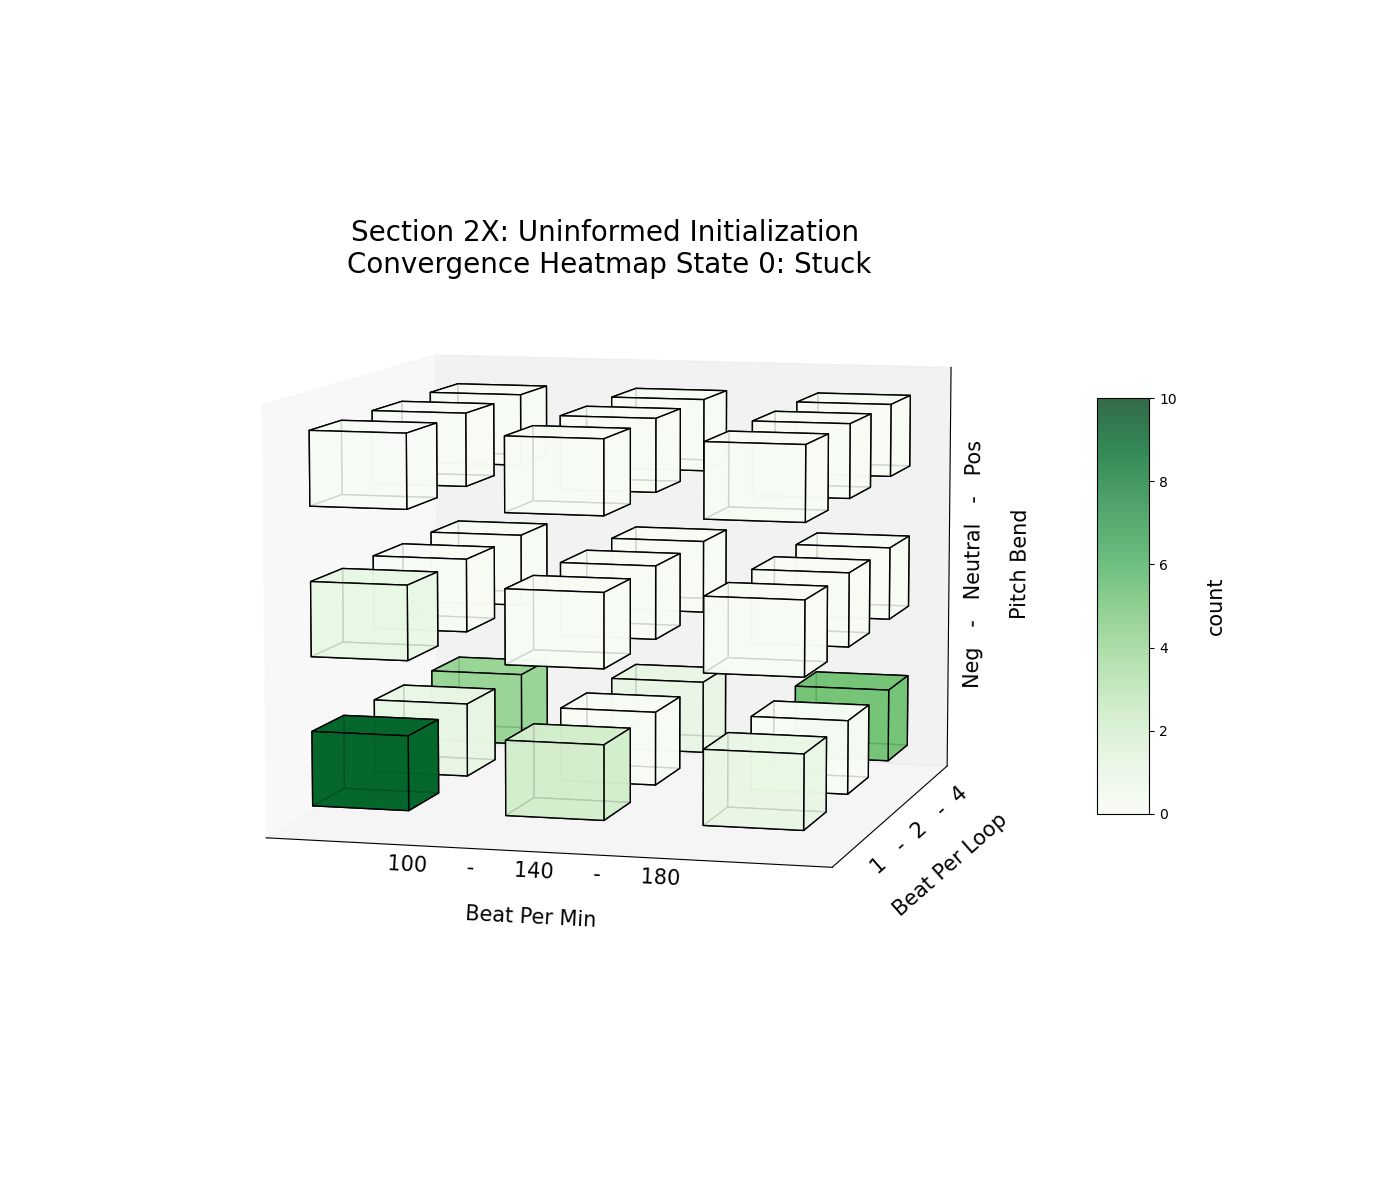

In [14]:

# sect2X_st0_hist_matrix
plot_3d_array(sect2X_st0_hist_matrix, sect2X_st0_hist_matrix_save, sect2X_st0_hist_matrix_title, plotter=True, norm_min=0, norm_max=10, scale_label="count", colour_map='Greens')


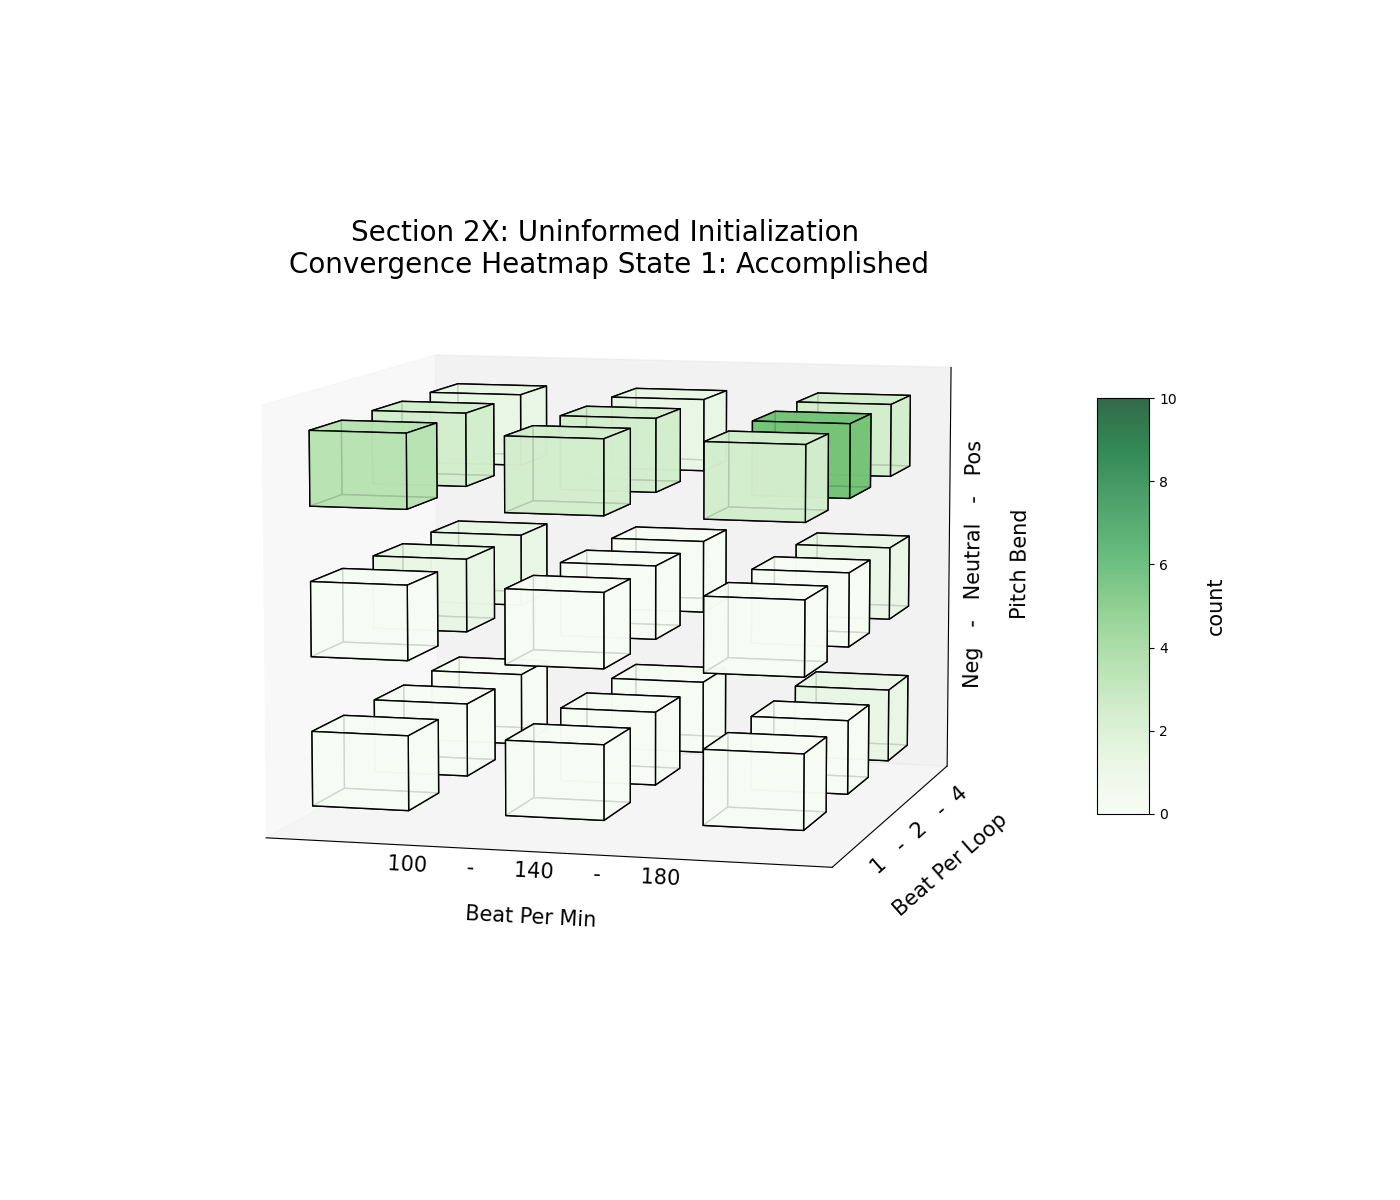

In [15]:

# sect2X_st1_hist_matrix
plot_3d_array(sect2X_st1_hist_matrix, sect2X_st1_hist_matrix_save, sect2X_st1_hist_matrix_title, plotter=True, norm_min=0, norm_max=10, scale_label="count", colour_map='Greens')


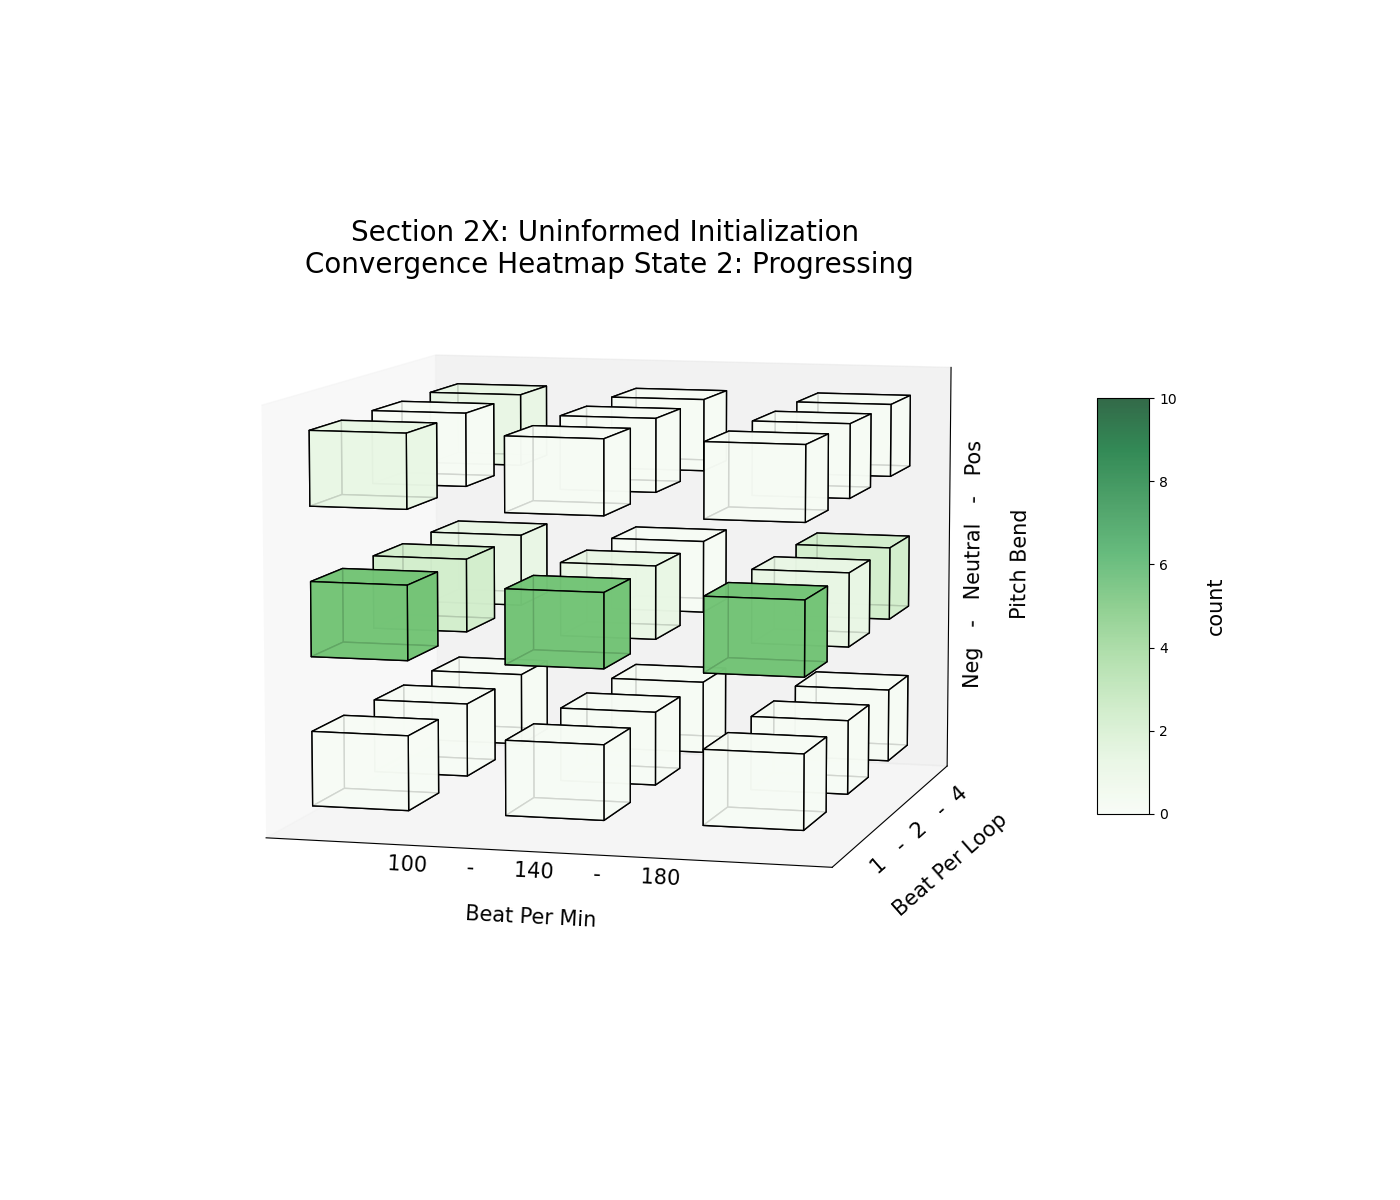

In [16]:

# sect2X_st2_hist_matrix
plot_3d_array(sect2X_st2_hist_matrix, sect2X_st2_hist_matrix_save, sect2X_st2_hist_matrix_title, plotter=True, norm_min=0, norm_max=10, scale_label="count", colour_map='Greens')


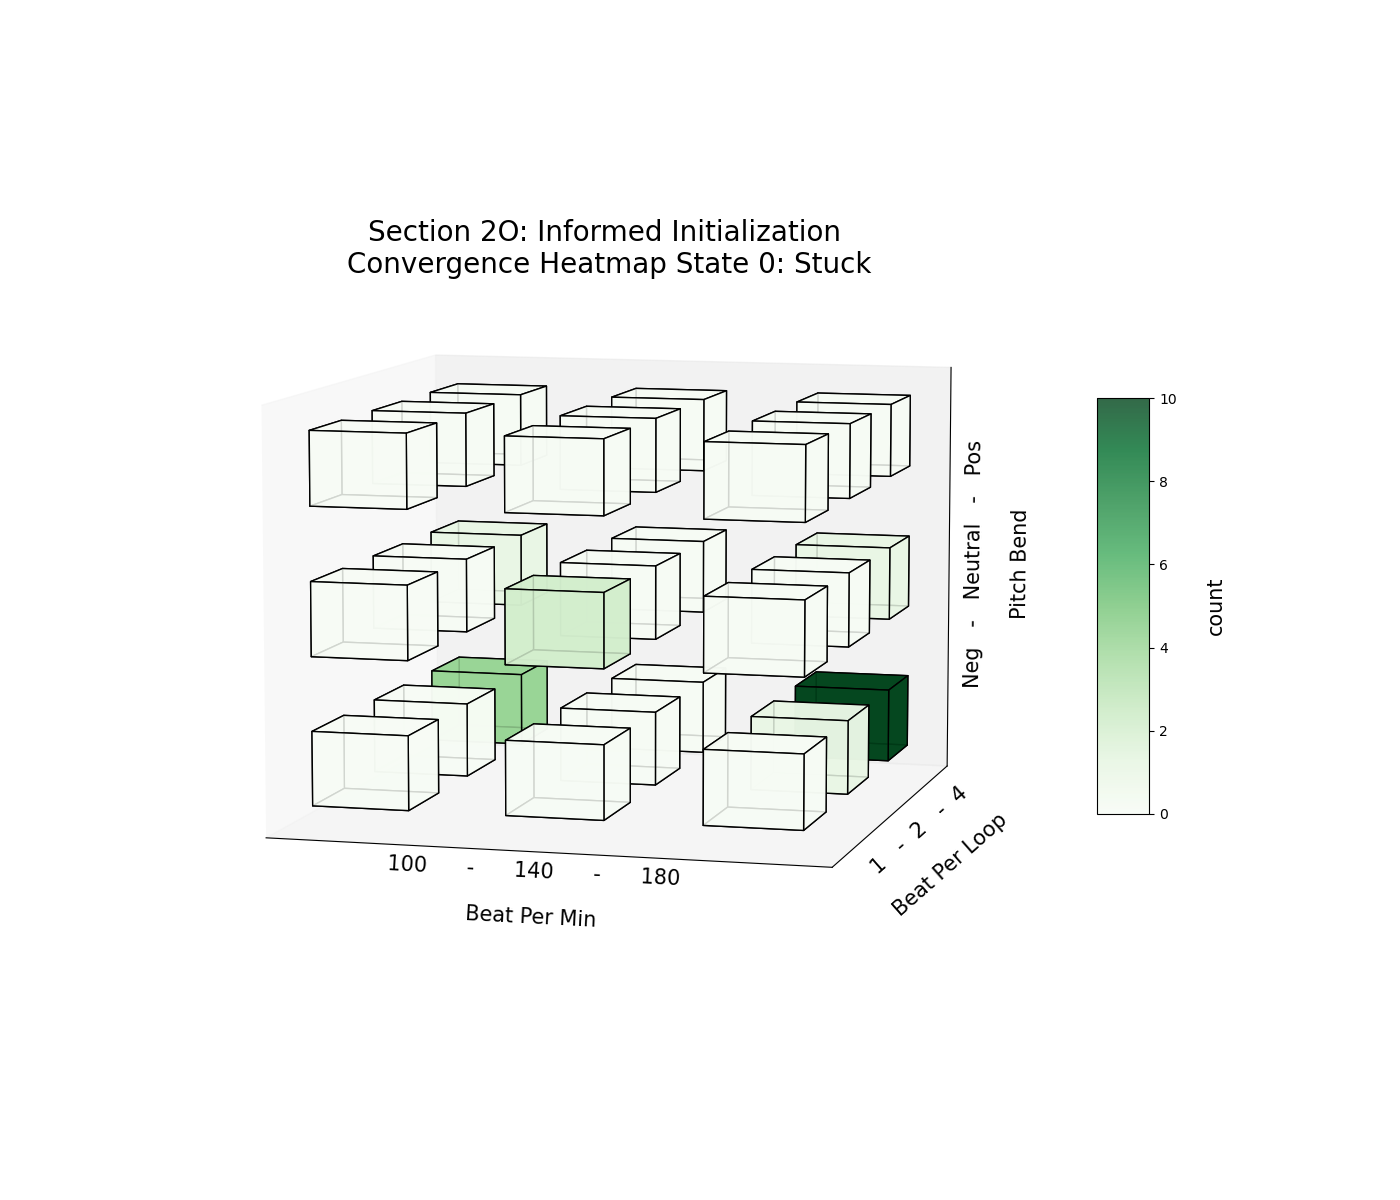

In [17]:

# sect2O_st0_hist_matrix
plot_3d_array(sect2O_st0_hist_matrix, sect2O_st0_hist_matrix_save, sect2O_st0_hist_matrix_title, plotter=True, norm_min=0, norm_max=10, scale_label="count", colour_map='Greens')


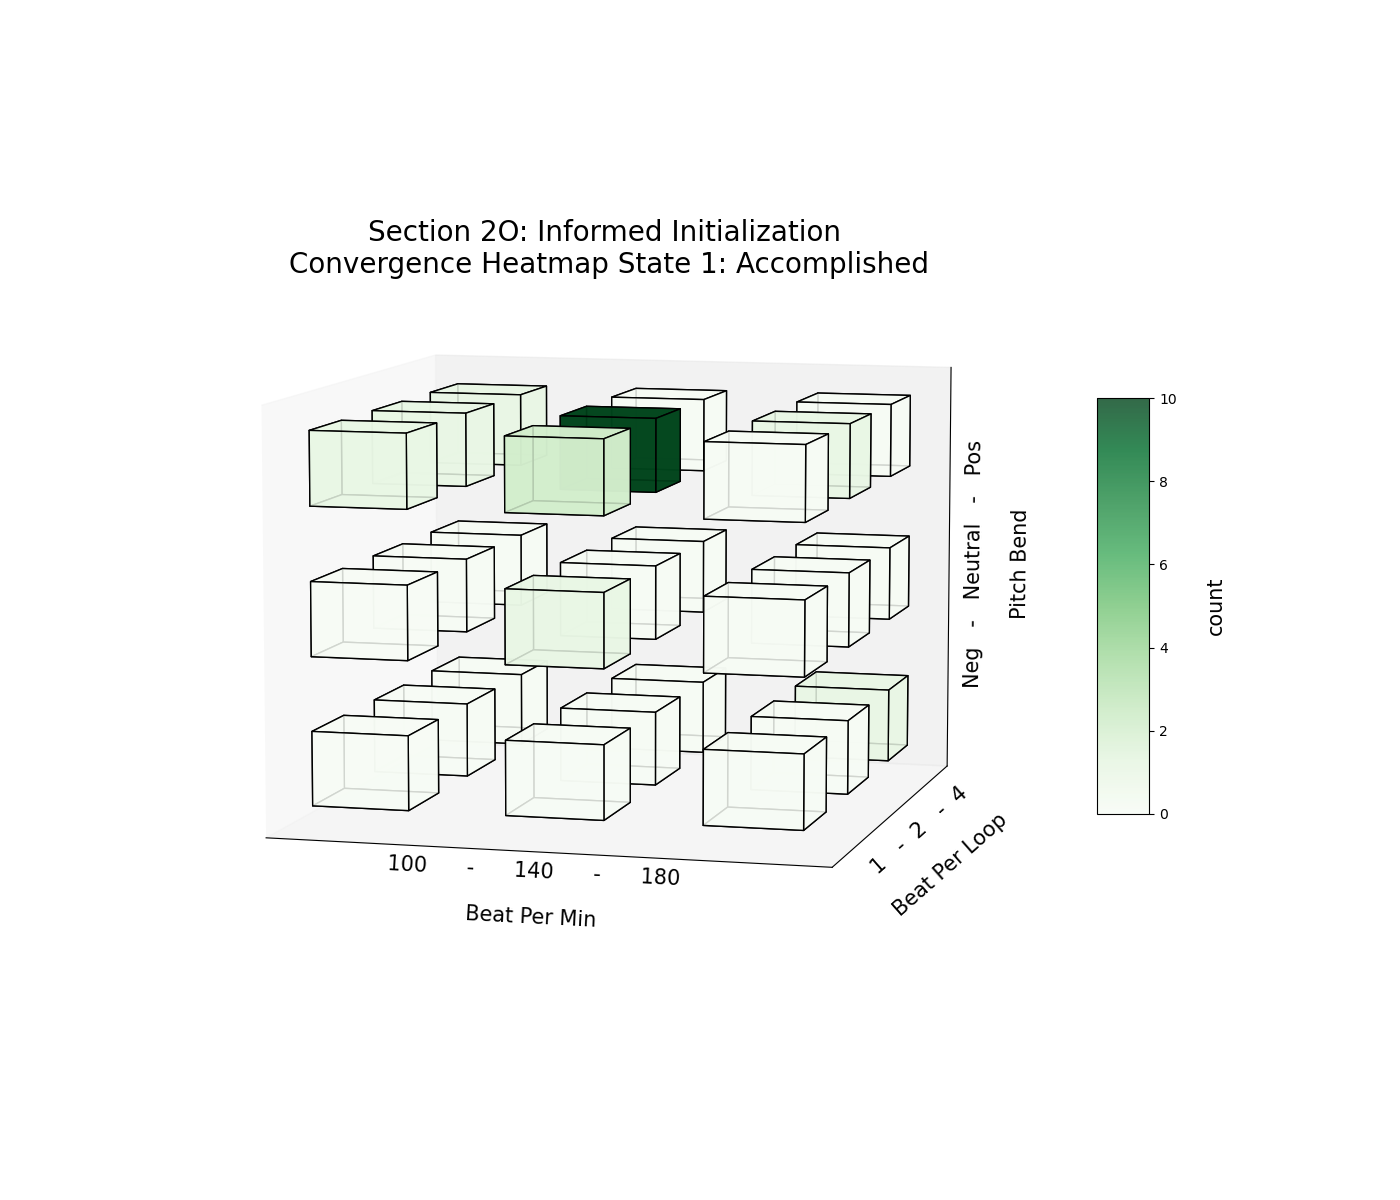

In [18]:

# sect2O_st1_hist_matrix
plot_3d_array(sect2O_st1_hist_matrix, sect2O_st1_hist_matrix_save, sect2O_st1_hist_matrix_title, plotter=True, norm_min=0, norm_max=10, scale_label="count", colour_map='Greens')


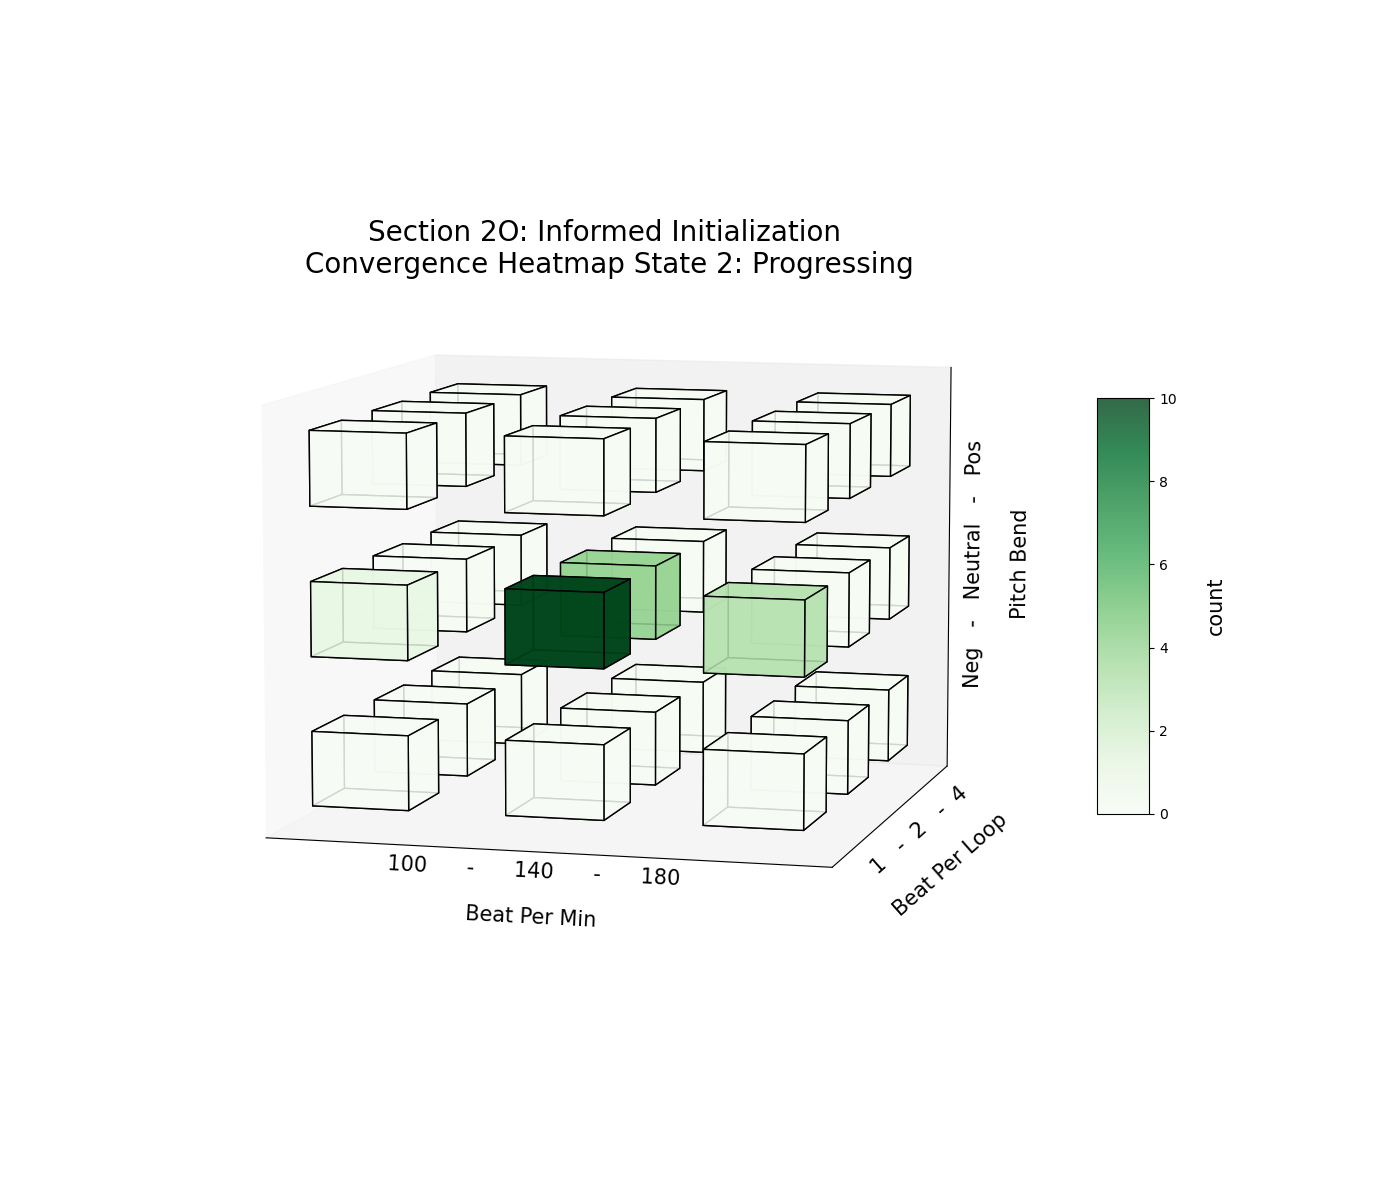

In [19]:

# sect2O_st2_hist_matrix
plot_3d_array(sect2O_st2_hist_matrix, sect2O_st2_hist_matrix_save, sect2O_st2_hist_matrix_title, plotter=True, norm_min=0, norm_max=10, scale_label="count", colour_map='Greens')


## Also print them as Histograms so you can see quantitative distribution 

In [20]:
print(f"sect2X_st0_hist_matrix: \n{sect2X_st0_hist_matrix}")
# print()
# print(f"sect2X_st1_hist_matrix: \n{sect2X_st1_hist_matrix}")
# print()
# print(f"sect2X_st2_hist_matrix: \n{sect2X_st2_hist_matrix}")
# print()
# print(f"sect2O_st0_hist_matrix: \n{sect2O_st0_hist_matrix}")
# print()
# print(f"sect2O_st1_hist_matrix: \n{sect2O_st1_hist_matrix}")
# print()
# print(f"sect2O_st2_hist_matrix: \n{sect2O_st2_hist_matrix}")

sect2X_st0_hist_matrix: 
[[[9. 1. 0.]
  [1. 0. 0.]
  [4. 0. 0.]]

 [[2. 0. 0.]
  [0. 0. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [0. 0. 0.]
  [5. 0. 0.]]]


## Create these plots but as real Histograms

In [78]:
def hist_matrix_histplotter(hist_matrix, save_str, title_str, plotter=True):

    hist_x_list = []
    hist_y_list = []
    
    for param1_idx_123 in range(0, 3):          # BPM
        for param2_idx_123 in range(0, 3):      # BPL
            for param3_idx_123 in range(0, 3):  # PitchBend
            
                hist_x_list.append(str((param1_idx_123, param2_idx_123, param3_idx_123)))
                hist_y_list.append(hist_matrix[param1_idx_123, param2_idx_123, param3_idx_123])
            
    # print(f"hist_x_list: {len(hist_x_list)} \n{hist_x_list}")
    # print()
    # print(f"hist_y_list: {len(hist_y_list)} \n{hist_y_list}")    
    
    
    fig, axs = plt.subplots(figsize=(10, 6), layout='constrained')
    
    histo = plt.bar(hist_x_list, hist_y_list, color='green', edgecolor='black')

    axs.set_title(title_str, size = 20)
    axs.set_xlabel("\nParam Index [(P1, P2, P3) = (BPM, BPL, Pitch Bend)]\n", size = 15)
    axs.set_ylabel("\nCount\n", size = 15)
    
    axs.grid(color='black', linestyle='-', linewidth=0.1)
    
    axs.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    axs.yaxis.set_ticks(np.arange(0, 18, 1))
    
    fig.autofmt_xdate(rotation=75)

    
    # Save the fig
    plt.savefig(save_str, bbox_inches='tight', pad_inches=0.25)

    
    # Show the fig if plotter is not set to None
    if plotter:
        plt.show()

    if plotter == None:
        print(" Plots closed. ")
        matplotlib.pyplot.close()

In [79]:
sect2X_st0_hist_2d_save = "user_data/user_all/histograms/sect2X_st0_conv_histogram.png"
sect2X_st0_hist_2d_title = "Section 2X: Uninformed Initialization \nConvergence Histogram State 0: Stuck"

sect2X_st1_hist_2d_save = "user_data/user_all/histograms/sect2X_st1_conv_histogram.png"
sect2X_st1_hist_2d_title = "Section 2X: Uninformed Initialization \nConvergence Histogram State 1: Accomplished"

sect2X_st2_hist_2d_save = "user_data/user_all/histograms/sect2X_st2_conv_histogram.png"
sect2X_st2_hist_2d_title = "Section 2X: Uninformed Initialization \nConvergence Histogram State 2: Progressing"

sect2O_st0_hist_2d_save = "user_data/user_all/histograms/sect2O_st0_conv_histogram.png"
sect2O_st0_hist_2d_title = "Section 2O: Informed Initialization \nConvergence Histogram State 0: Stuck"

sect2O_st1_hist_2d_save = "user_data/user_all/histograms/sect2O_st1_conv_histogram.png"
sect2O_st1_hist_2d_title = "Section 2O: Informed Initialization \nConvergence Histogram State 1: Accomplished"

sect2O_st2_hist_2d_save = "user_data/user_all/histograms/sect2O_st2_conv_histogram.png"
sect2O_st2_hist_2d_title = "Section 2O: Informed Initialization \nConvergence Histogram State 2: Progressing"

/var/folders/vx/sqc7hy3d7tzbzb4vn45c7n8h0000gn/T/ipykernel_21175/2372840936.py:31: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate(rotation=75)


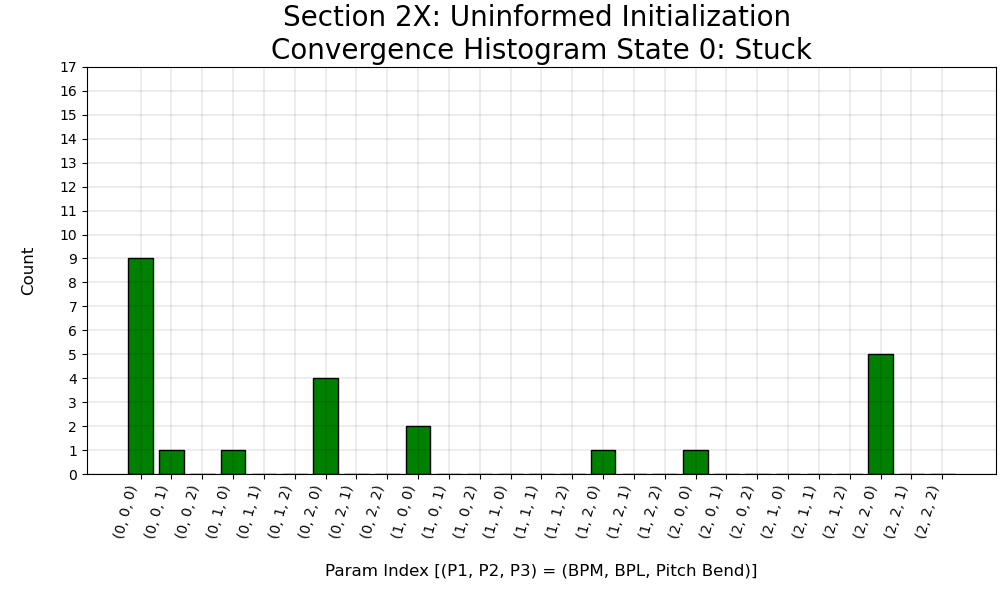

In [80]:
hist_matrix_histplotter(sect2X_st0_hist_matrix, save_str=sect2X_st0_hist_2d_save, title_str=sect2X_st0_hist_2d_title)

/var/folders/vx/sqc7hy3d7tzbzb4vn45c7n8h0000gn/T/ipykernel_21175/2372840936.py:31: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate(rotation=75)


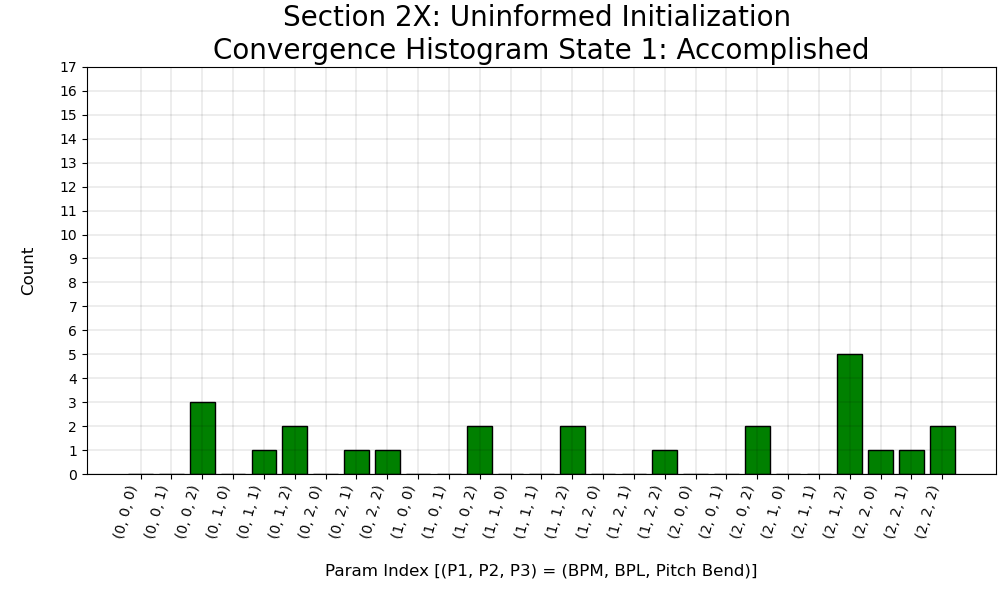

In [81]:
hist_matrix_histplotter(sect2X_st1_hist_matrix, save_str=sect2X_st1_hist_2d_save, title_str=sect2X_st1_hist_2d_title)

/var/folders/vx/sqc7hy3d7tzbzb4vn45c7n8h0000gn/T/ipykernel_21175/2372840936.py:31: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate(rotation=75)


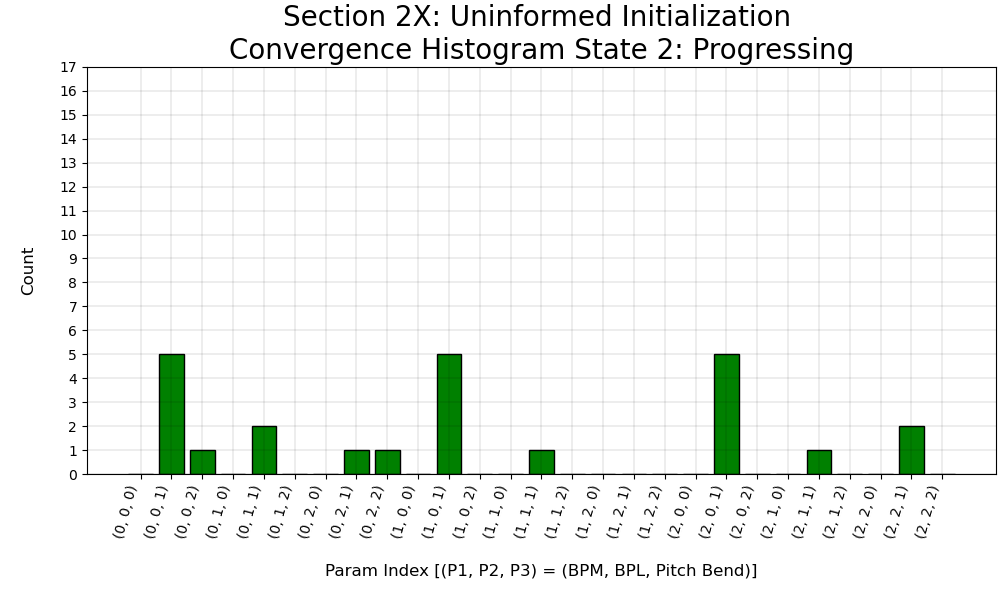

In [82]:
hist_matrix_histplotter(sect2X_st2_hist_matrix, save_str=sect2X_st2_hist_2d_save, title_str=sect2X_st2_hist_2d_title)

/var/folders/vx/sqc7hy3d7tzbzb4vn45c7n8h0000gn/T/ipykernel_21175/2372840936.py:31: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate(rotation=75)


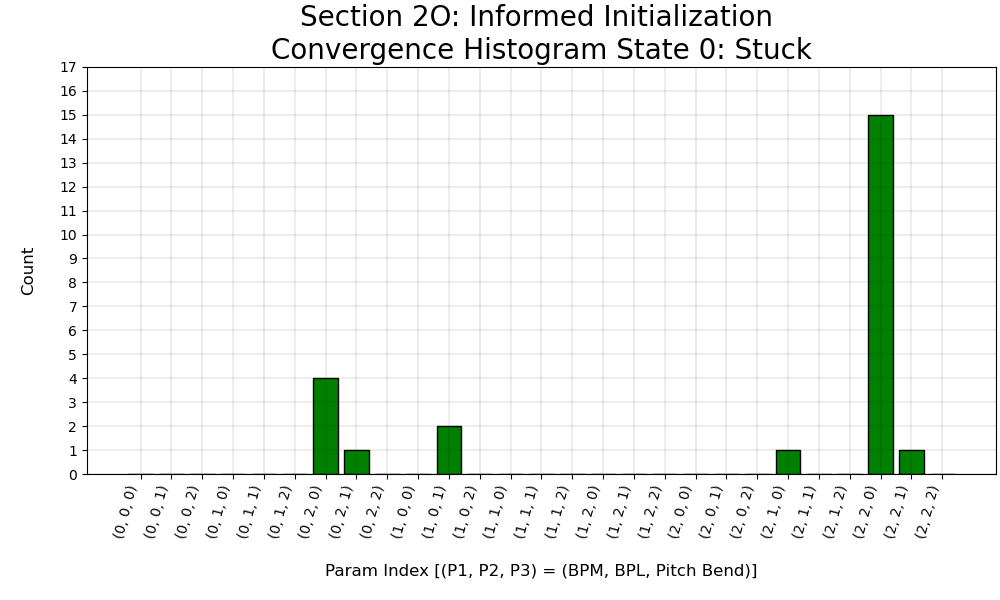

In [83]:
hist_matrix_histplotter(sect2O_st0_hist_matrix, save_str=sect2O_st0_hist_2d_save, title_str=sect2O_st0_hist_2d_title)

/var/folders/vx/sqc7hy3d7tzbzb4vn45c7n8h0000gn/T/ipykernel_21175/2372840936.py:31: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate(rotation=75)


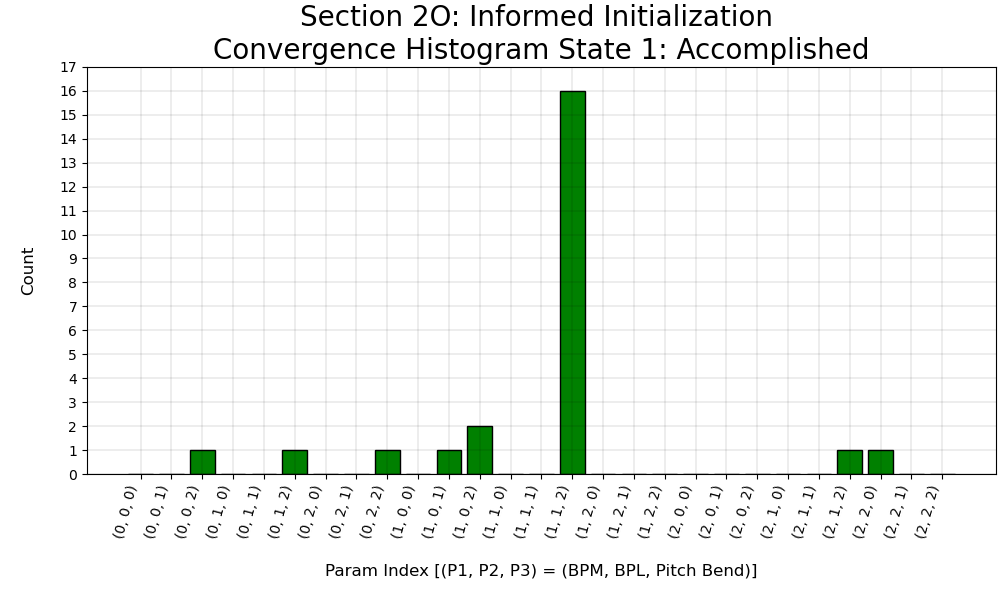

In [84]:
hist_matrix_histplotter(sect2O_st1_hist_matrix, save_str=sect2O_st1_hist_2d_save, title_str=sect2O_st1_hist_2d_title)

/var/folders/vx/sqc7hy3d7tzbzb4vn45c7n8h0000gn/T/ipykernel_21175/2372840936.py:31: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate(rotation=75)


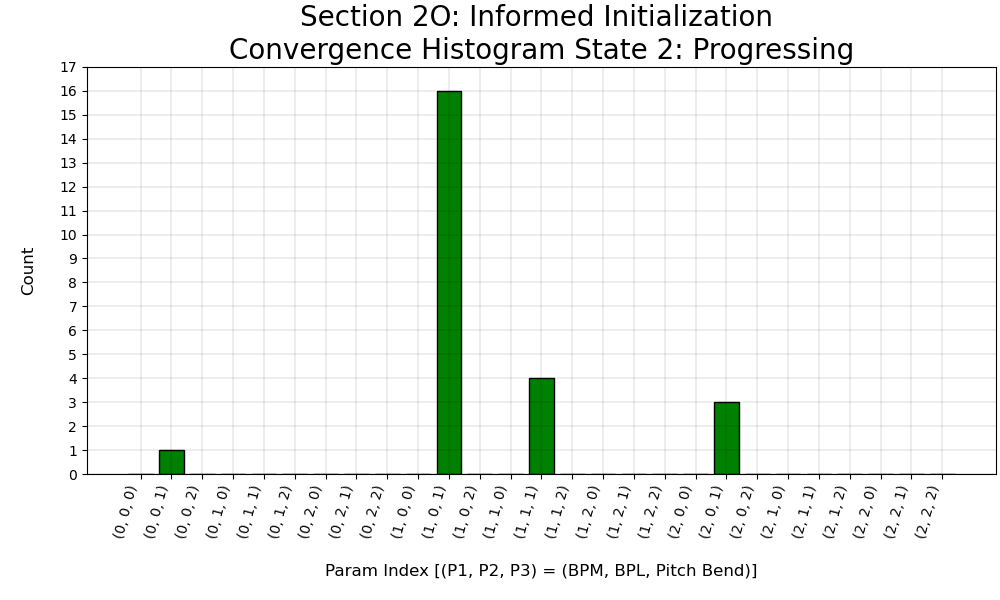

In [85]:
hist_matrix_histplotter(sect2O_st2_hist_matrix, save_str=sect2O_st2_hist_2d_save, title_str=sect2O_st2_hist_2d_title)